# Loading Data

In [ ]:
import pandas as pd

data1 = pd.read_csv( 'data/train.csv')

data2 = pd.read_csv( 'data/comments.csv')

data = pd.concat( ( data1, data2)).reset_index(drop=True)

import sklearn
data = sklearn.utils.shuffle( data)

data = data.drop_duplicates(subset='comment', keep='first')

X = data[ 'comment']
y = data[ 'label']

In [ ]:
print( "Number of Comments in data:", X.shape[0])

Number of Comments in data: 2682


# Data Visualization

<Axes: xlabel='label', ylabel='count'>

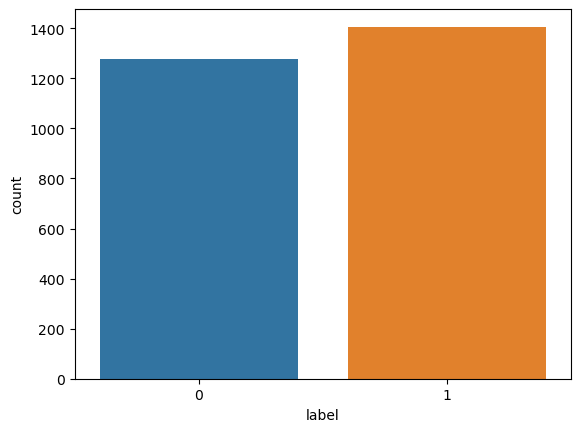

In [ ]:
import seaborn as sns

sns.countplot( x=y)

# Spliting Data to Train/Test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify = y)

In [ ]:
print( "Train size:", X_train.shape[0], '\nTest size:', X_test.shape[0])

Train size: 2145 
Test size: 537


# Loading Word2Vec Model

In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("models/word2vec-arabic.model")

# Intializing HyperParameters

In [ ]:
import numpy as np

sentence_lengths = 610

max_length = int( np.percentile(sentence_lengths, 95))
max_length = 128

embedding_dim = w2v_model.vector_size

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts( X_train)

total_words = len( tokenizer.word_index)

# Converting Test to Seuence and then Pad

In [ ]:
from keras.preprocessing.sequence import pad_sequences

train_sequences = tokenizer.texts_to_sequences( X_train)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')


test_sequences = tokenizer.texts_to_sequences( X_test)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Defining CallBacks

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

EarlyStopping = EarlyStopping(monitor='val_loss', 
                                patience=6, 
                                restore_best_weights=True)

model_save = ModelCheckpoint('best_model.keras',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss',
                             mode = 'min', verbose= 1)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=5,
                            verbose=0,
                            mode="max",
                            min_delta=0.0001)

# Initilizing Embedding Metrix

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Building Model

In [ ]:
from tensorflow.keras.layers import  Embedding, Flatten, Dense, Bidirectional, LSTM
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam


model = Sequential()

model.add( Embedding(total_words+1, embedding_dim, weights=[ embedding_matrix], input_length=max_length, trainable=False),)
model.add( Bidirectionamodel.add( LSTM(16)),)
model.add( Flatten(),)
model.add( BatchNormalization(),)
model.add( Dropout(0.50),)
model.add( Dense( embedding_dim, activation='relu'),)
model.add( BatchNormalization())
model.add( Dropout(0.30))
model.add( Dense(8,activation='relu'))
model.add( Dense(1,activation='sigmoid'))




model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

In [173]:
print("Shape of embedding_matrix:", embedding_matrix.shape)

print("Total number of words:", total_words)


Shape of embedding_matrix: (17487, 100)
Total number of words: 17486


# Visualizing Summary of Model

In [174]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 610, 100)          1748700   
                                                                 
 dense_31 (Dense)            (None, 610, 128)          12928     
                                                                 
 dense_32 (Dense)            (None, 610, 64)           8256      
                                                                 
 dense_33 (Dense)            (None, 610, 32)           2080      
                                                                 
 dense_34 (Dense)            (None, 610, 1)            33        
                                                                 
Total params: 1771997 (6.76 MB)
Trainable params: 1771997 (6.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training the Model

In [175]:
history = model.fit( train_padded_sequences, y_train,
                       validation_split=0.2,
                       epochs = 100,
                       batch_size= 16,
                       callbacks=[ EarlyStopping, model_save, rlr])

Epoch 1/100


108/108 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5252
Epoch 1: val_loss improved from inf to 0.69202, saving model to best_model.keras
108/108 [==============================] - 9s 63ms/step - loss: 0.6932 - accuracy: 0.5252 - val_loss: 0.6920 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 2/100
108/108 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5345
Epoch 2: val_loss improved from 0.69202 to 0.69137, saving model to best_model.keras
108/108 [==============================] - 5s 48ms/step - loss: 0.6909 - accuracy: 0.5345 - val_loss: 0.6914 - val_accuracy: 0.5316 - lr: 0.0010
Epoch 3/100
108/108 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.5370
Epoch 3: val_loss improved from 0.69137 to 0.69128, saving model to best_model.keras
108/108 [==============================] - 6s 60ms/step - loss: 0.6899 - accuracy: 0.5370 - val_loss: 0.6913 - val_accuracy: 0.5329 - lr: 0.0010
Epoch 4/100
108/108 [==============

# Visualizinf Training Progress

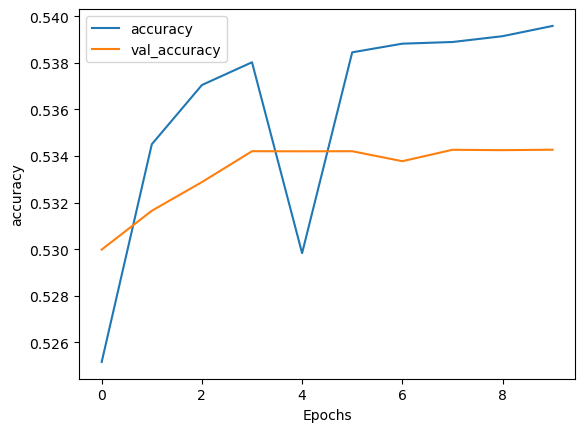

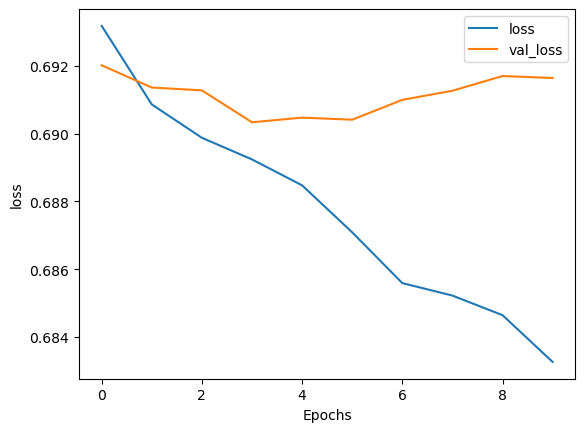

In [176]:
import matplotlib.pyplot as plt

def plot_graphs(model, string):
    plt.plot(model.history[string])
    plt.plot(model.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Model performence on Test Data

In [177]:
predicted_test = model.predict( test_padded_sequences)
binary_predictions = ( predicted_test > 0.5).astype(int)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix( y_test, binary_predictions)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Réelle',fontsize=13)
plt.title('Matrice de confusion',fontsize=17)
plt.show()

17/17 [==============================] - 1s 64ms/step


ValueError: Classification metrics can't handle a mix of binary and unknown targets

In [ ]:
from tensorflow.keras.models import load_model

the_model = load_model('best_model.keras')

model.evaluate(  test_padded_sequences, y_test)

17/17 [==============================] - 0s 9ms/step - loss: 0.6900 - accuracy: 0.5332


[0.690022885799408, 0.5332173109054565]